In [1]:
import numpy as np
import random
from structures import *
import matplotlib.pyplot as plt

todo is:
1. simulate checking out ebikes (i wrote it into in the classes, just needed to add to the simulation) ✅
2. add reservations (same thing – it’s already in the classes)  ✅
3. simulate time delays from transferring video
4. simulate ebike conversion ✅
5. run some simulations and plot them!

In [73]:
TIMESTEPS = 120   # 1 timestep = 5 min
N_STATIONS = 12
DOCKS_PER_STATION = 10
INIT_BIKES_PER_STATION = 8
RESERVATION_LIMIT = 5

RIDE_DENSITY_AVG = 10
RIDE_DENSITY_STD = 2
RIDE_LEN_AVG = 4
RIDE_LEN_STD = 3

WANT_EBIKE_PROB = 0.3

RESERVATION_DENSITY_AVG = 5
RESERVATION_DENSITY_STD = 2


def create_stations(reservation_limit=RESERVATION_LIMIT):
    stations = []
    for station in range(N_STATIONS):
        # currently no EBIKES
        stations.append(Station(DOCKS_PER_STATION, int(INIT_BIKES_PER_STATION*(1-WANT_EBIKE_PROB)), int(INIT_BIKES_PER_STATION*WANT_EBIKE_PROB), reservation_limit))
    return stations

def count_failed_reservations(stations):
    """
    Counts the number of failed reservations for a given timestep
    """
    n_reservations = sample_norm_int(RESERVATION_DENSITY_AVG, RESERVATION_DENSITY_STD, 0)
    count = 0
    for _ in range(n_reservations):
        station = random.choice(stations)
        bike_type = "SBIKE" if random.random() > WANT_EBIKE_PROB else "EBIKE"
        if not station.reserve_bike(bike_type):
            count += 1
    return count


def start_rides(stations, time, current_rides, n_rides_started=False): 
    """
    Start new rides for a given timestep and return the number of failed checkouts

    Update the current_rides list with the new rides
    """
    if not n_rides_started:
        n_rides_started = sample_norm_int(RIDE_DENSITY_AVG, RIDE_DENSITY_STD, 0)

    count_fails = 0
    count_ebikes_conversions = 0
    for _ in range(n_rides_started):
        # choose ride attributes
        start = random.choice(stations)
        destination = random.choice(stations)
        length = sample_norm_int(RIDE_LEN_AVG, RIDE_LEN_STD, 1)

        # choose bike type that user wants to check out
        desired_btype = "SBIKE" if random.random() > WANT_EBIKE_PROB else "EBIKE"

        if start.check_out(desired_btype, can_convert_ebikes=True):
            # checkout successful
            new_ride = Ride(start, destination, time, length)
            current_rides.append(new_ride)
        else:
            # no bikes available
            count_fails += 1
    return count_fails, count_ebikes_conversions


def run_simulation():
    rides_log = [0]
    failed_checkout_log = [0]
    failed_dock_log = [0]
    failed_reservation_log = [0]
    ebike_conversion_log = [0]
    
    stations = create_stations(reservation_limit=2)
    current_rides = []
    
    # run simulation!
    for idx, time in enumerate(range(TIMESTEPS)):
        # let the idx be the number of rides started
        n_attempted_rides = idx
        n_dock_fails = 0
        n_reservation_fails = 0
        
        n_checkout_fails, n_ebikes_conversions = start_rides(stations, time, current_rides, n_attempted_rides)

        n_reservation_fails = count_failed_reservations(stations)
        
        # check for rides finishing
        updated_current_rides = []
        for ride in current_rides:
            if ride.start_time + ride.length <= time:   # check if they're done riding
                if ride.destination.return_bike("SBIKE"):  # try to return bike
                    # return successful
                    pass
                else:
                    # return failed
                    updated_current_rides.append(ride)
                    n_dock_fails += 1
            else:
                updated_current_rides.append(ride)
    
        rides_log.append(len(current_rides))
        failed_checkout_log.append(n_checkout_fails)
        failed_dock_log.append(n_dock_fails)
        failed_reservation_log.append(n_reservation_fails)
        ebike_conversion_log.append(n_ebikes_conversions)

        current_rides = updated_current_rides

    return rides_log, failed_checkout_log, failed_dock_log, failed_reservation_log, ebike_conversion_log


rides, checkout_fails, dock_fails, reserve_fails, ebike_conversions = run_simulation()
rides = [(ride / TIMESTEPS)*100 for ride in rides]

Text(0.5, 0, 'Time (minutes)')

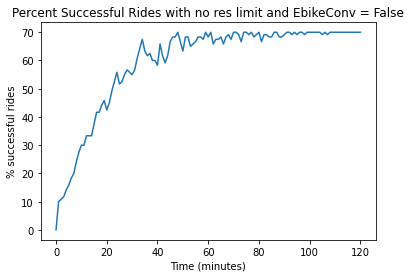

In [70]:
plt.plot(rides, label="Sucessful rides with res limit of 0 and e bike conversion False")
plt.title("Percent Successful Rides with no res limit and EbikeConv = False")
plt.ylabel("% successful rides")
plt.xlabel("Time (minutes)")


Text(0.5, 0, 'Time (minutes)')

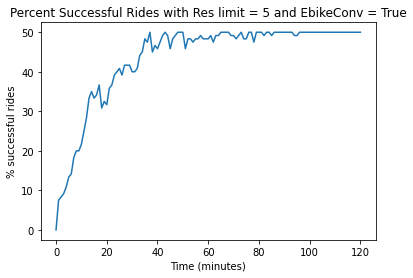

In [74]:
# x axis is assumed based on length of the arrays
plt.plot(rides, label="Sucessful rides with Res limit + Ebike Conversion")
plt.title("Percent Successful Rides with Res limit = 5 and EbikeConv = True")
plt.ylabel("% successful rides")
plt.xlabel("Time (minutes)")


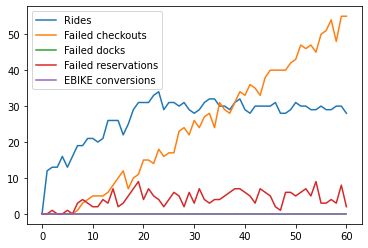

In [25]:
plt.plot(rides, label="Rides")
plt.plot(checkout_fails, label="Failed checkouts")
plt.plot(dock_fails, label="Failed docks")
plt.plot(reserve_fails, label="Failed reservations")
plt.plot(ebike_conversions, label="EBIKE conversions")
plt.legend()

## Show the merit of reservation limits and e bikes conversions